In [1]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess import range_fft, doppler_fft, range_doppler_fft
import scipy.signal as signal
import tensorflow as tf
import os
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb
from toolbox.helper import get_gzipped_model_size, evaluate_tflite
import tensorflow_model_optimization as tfmot

NUM_SAMPLES_PER_FRAME = 64
NUM_CHIRPS_PER_FRAME = 16
NUM_CHANNELS = 3

def save(model : tf.keras.Model, filepath : str):
    with open(filepath, 'wb') as f:
        f.write(model)
    print("Saved to " + filepath)

current_path = os.getcwd()
parent_path = os.path.abspath(os.path.join(current_path, os.pardir))

Range-Doppler transform

In [2]:
def preprocess(raw_frames : np.ndarray):
    range_window_func = lambda x: signal.windows.hamming(x, NUM_SAMPLES_PER_FRAME)
    range_data = range_fft(raw_frames, range_window_func)
    mti_data = range_data - np.mean(range_data, axis=-1, keepdims=True)
    doppler_data = doppler_fft(mti_data)
    rdi = np.mean(abs(doppler_data), axis=0) # Average across channels
    return rdi

# Dataset generation

In [3]:
X_train = []
y_train = []

train_path = os.path.join(parent_path, "data")
filenames = os.listdir(train_path)

for filename in os.listdir(train_path):
    data = np.load(os.path.join(train_path, filename))
    label = None

    if filename[5] == "0":
        label = 0
    else:
        label = 1

    for frame in data:
        preprocessed = preprocess(frame)
        preprocessed = np.reshape(preprocessed, (16, 32, 1))
        X_train.append(preprocessed)
        y_train.append(label)

X_train = np.float32(np.asarray(X_train))
y_train = np.asarray(y_train)
assert (X_train.shape[0] == y_train.shape[0])

In [4]:
X_train, y_train = shuffle(X_train, y_train)

train_size = X_train.shape[0]
val_split = 0.15
test_split = 0.15
val_size = int(train_size * val_split)
test_size = int(train_size * test_split)
train_size = train_size - val_size - test_size

X_val = X_train[ : val_size]
y_val = y_train[ : val_size]
X_test = X_train[val_size : val_size + test_size]
y_test = y_train[val_size : val_size + test_size]
X_train = X_train[val_size + test_size : ]
y_train = y_train[val_size + test_size : ]

# Model training and validation

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 32, 1)),
    tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, activation="relu"),
    # tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 14, 30, 1)        10        
 Conv2D)                                                         
                                                                 
 flatten (Flatten)           (None, 420)               0         
                                                                 
 dense (Dense)               (None, 10)                4210      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 4,242
Trainable params: 4,242
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(train_dataset, validation_data=val_dataset, epochs=1)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
868/868 [==============================] - 10s 10ms/step - loss: 0.3362 - accuracy: 0.9859 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 2/5
868/868 [==============================] - 7s 8ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 4.9812e-04 - val_accuracy: 0.9998
Epoch 3/5
868/868 [==============================] - 7s 8ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 4.9535e-08 - val_accuracy: 1.0000
Epoch 4/5
868/868 [==============================] - 7s 8ms/step - loss: 0.0364 - accuracy: 0.9969 - val_loss: 0.0109 - val_accuracy: 0.9980
Epoch 5/5
868/868 [==============================] - 7s 8ms/step - loss: 9.6082e-04 - accuracy: 0.9999 - val_loss: 1.7191e-06 - val_accuracy: 1.0000


In [7]:
model.evaluate(X_test, y_test)

186/186 [==============================] - 1s 6ms/step - loss: 4.8908e-07 - accuracy: 1.0000


[4.890836180493352e-07, 1.0]

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
epochs = range(len(acc))

186/186 [==============================] - 1s 6ms/step


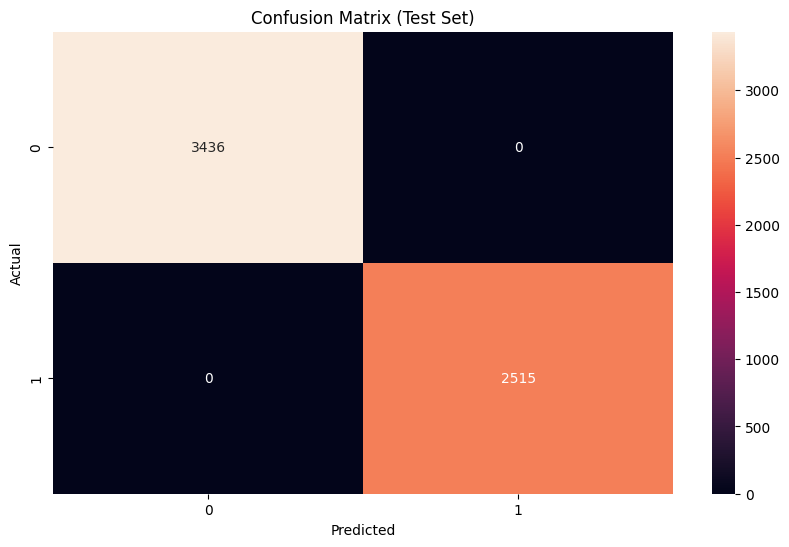

In [9]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
correct = (y_pred == y_test)
accuracy = correct.sum() / correct.size
cm = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [10]:
model.save(parent_path + "models/u_model.h5")

In [16]:
# test_model = tf.keras.models.load_model(parent_path + "/u_model.h5")
# tries = 0
# for i in range(50000):
#     if y_train[i] == 1:
#         pred = test_model.predict(np.array([X_test[i],]), verbose=False)
#         print(i)
#         print("Expected: ", y_test[i])
#         print("Predicted: ", np.argmax(pred[0]))
#         tries += 1
#         if tries > 10:
#             break

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp5xie9hca\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp5xie9hca\assets


In [12]:
tflite_model_path = parent_path
tf.io.write_file(parent_path + "/" + "models/u_model.tflite", tflite_model)

# Post-training quantisation

In [19]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

q_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpytax2dor\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpytax2dor\assets
c:\Users\Zaman\scoop\apps\miniconda3\current\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [30]:
save(q_model, os.path.join(parent_path, "models/q_model.tflite"))

Saved to c:\Users\Zaman\Documents\GitHub Repos\research_internship\models/q_model.tflite


# Pruning + post-training quantisation

In [13]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2

num_images = X_train.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model = tf.keras.models.load_model(parent_path + "models/u_model.h5")
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_depthwi  (None, 14, 30, 1)        11        
 se_conv2d (PruneLowMagnitud                                     
 e)                                                              
                                                                 
 prune_low_magnitude_flatten  (None, 420)              1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense (  (None, 10)               8412      
 PruneLowMagnitude)                                              
                                                     

In [14]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                  callbacks=callbacks)

Epoch 1/2
217/217 [==============================] - 9s 19ms/step - loss: 0.4299 - accuracy: 0.9825 - val_loss: 0.1378 - val_accuracy: 0.9805
Epoch 2/2
217/217 [==============================] - 4s 20ms/step - loss: 4.0939 - accuracy: 0.9287 - val_loss: 0.0636 - val_accuracy: 0.9882


In [17]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp701z_bat\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp701z_bat\assets


In [18]:
save(pruned_tflite_model, os.path.join(parent_path, "models/p_model.tflite"))

Saved to c:\Users\Zaman\Documents\GitHub Repos\research_internship\models/p_model.tflite


Quantising pruned model

In [27]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

pq_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpob03r42p\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpob03r42p\assets
c:\Users\Zaman\scoop\apps\miniconda3\current\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [28]:
save(pq_model, os.path.join(parent_path, "models/pq_model.tflite"))

Saved to c:\Users\Zaman\Documents\GitHub Repos\research_internship\models/pq_model.tflite


# Clustering + post-training quantisation

In [53]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 3,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

model = tf.keras.models.load_model(parent_path + "models/u_model.h5")

clustered_model = cluster_weights(model, **clustering_params)
clustered_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

clustered_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_depthwise_conv2d (C  (None, 14, 30, 1)        10        
 lusterWeights)                                                  
                                                                 
 cluster_flatten (ClusterWei  (None, 420)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 10)               8413      
 ts)                                                             
                                                                 
 cluster_dense_1 (ClusterWei  (None, 2)                45        
 ghts)                                                           
                                                                 
Total params: 8,468
Trainable params: 4,248
Non-trainabl

In [54]:
clustered_model.fit(X_train, y_train, validation_data=(X_val, y_val))

868/868 [==============================] - 8s 7ms/step - loss: 0.2760 - accuracy: 0.9952 - val_loss: 2.6442e-09 - val_accuracy: 1.0000


In [55]:
model_for_export = tfmot.clustering.keras.strip_clustering(clustered_model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
clustered_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpsz0nc_a0\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmpsz0nc_a0\assets


In [56]:
save(clustered_tflite_model, os.path.join(parent_path, "models/c_model.tflite"))

Saved to c:\Users\Zaman\Documents\GitHub Repos\research_internship\models/c_model.tflite


Quantising clustered model

In [57]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

cq_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp06z39fk6\assets


INFO:tensorflow:Assets written to: C:\Users\Zaman\AppData\Local\Temp\tmp06z39fk6\assets
c:\Users\Zaman\scoop\apps\miniconda3\current\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [58]:
save(cq_model, os.path.join(parent_path, "models/cq_model.tflite"))

Saved to c:\Users\Zaman\Documents\GitHub Repos\research_internship\models/cq_model.tflite


# Final comparison

In [5]:
u_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/u_model.tflite"), X_test, y_test, verbose=False)
q_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/q_model.tflite"), X_test, y_test, verbose=False)
p_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/p_model.tflite"), X_test, y_test, verbose=False)
c_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/c_model.tflite"), X_test, y_test, verbose=False)
pq_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/pq_model.tflite"), X_test, y_test, verbose=False)
cq_model_accuracy = evaluate_tflite(os.path.join(parent_path, "models/cq_model.tflite"), X_test, y_test, verbose=False)
u_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/u_model.tflite"))
q_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/q_model.tflite"))
p_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/p_model.tflite"))
c_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/c_model.tflite"))
pq_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/pq_model.tflite"))
cq_model_size = get_gzipped_model_size(os.path.join(parent_path, "models/cq_model.tflite"))

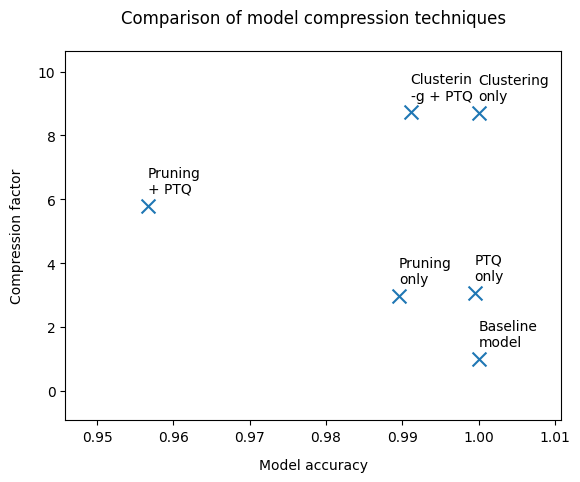

In [6]:
compression_factors = {
    "Baseline\nmodel" : 1.0,
    "PTQ\nonly" : u_model_size / q_model_size,
    "Pruning\nonly" : u_model_size / p_model_size,
    "Pruning\n+ PTQ" : u_model_size / pq_model_size,
    "Clustering\nonly" : u_model_size / c_model_size,
    "Clusterin\n-g + PTQ" : u_model_size / cq_model_size
}

model_accuracy = {
    "Baseline\nmodel" : u_model_accuracy,
    "PTQ\nonly" : q_model_accuracy,
    "Pruning\nonly" : p_model_accuracy,
    "Pruning\n+ PTQ" : pq_model_accuracy,
    "Clustering\nonly" : c_model_accuracy,
    "Clusterin\n-g+ PTQ" : cq_model_accuracy
}

x = list(model_accuracy.values())
y = list(compression_factors.values())
plt.scatter(x, y, 100, marker="x")
# plt.xlim(0.95, 1.01)
plt.margins(0.25) # 5% padding in all directions
plt.xlabel("Model accuracy", labelpad=10)
plt.ylabel("Compression factor", labelpad=10)
for i, txt in enumerate(list(compression_factors.keys())):
    plt.annotate(txt, (x[i], y[i] + 0.4))
    # if i == 0:
    #     plt.text(x[i] - 0.01, y[i] + 0.3, txt)
    # else:
    #     plt.text(x[i] - 0.01, y[i], txt)
plt.title("Comparison of model compression techniques", pad=20)
plt.show()


In [7]:
model_accuracy

{'Baseline\nmodel': 1.0,
 'PTQ\nonly': 0.9994958830448664,
 'Pruning\nonly': 0.9895815829272391,
 'Pruning\n+ PTQ': 0.9566459418585112,
 'Clustering\nonly': 1.0,
 'Clusterin\n-g+ PTQ': 0.9910939337926399}

In [8]:
compression_factors

{'Baseline\nmodel': 1.0,
 'PTQ\nonly': 3.0705732946298987,
 'Pruning\nonly': 2.9672159887798037,
 'Pruning\n+ PTQ': 5.798218568002741,
 'Clustering\nonly': 8.7107565620175,
 'Clusterin\n-g + PTQ': 8.724226804123711}